In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True

despine_offset = 10
despine_trim = True

### Load and plot data showing per-chromosome mean replication timing profiles of different PERT and ENCODE cell types

In [3]:
def load_encode_repliseq():
    columns = [
        'chr',
        'start',
        'end',
        'mcf7_rt',
        'bg02es_rt',
        'bj_rt',
        'gm06990_rt',
        'gm12801_rt',
        'gm12812_rt',
        'gm12813_rt',
        'gm12878_rt',
        'helas3_rt',
        'hepg2_rt',
        'huvec_rt',
        'imr90_rt',
        'k562_rt',
        'sknsh_rt',
        'nhek_rt',
    ]

    encode_filename = '/work/shah/users/weinera2/projects/scdna_replication_paper/analysis/simulation/D1.0/s_phase_cells_pyro_composite_filtered.tsv'
    encode = pd.read_csv(encode_filename, sep='\t', low_memory=True, usecols=columns).drop_duplicates()
    encode['start'] += 1
    encode = encode.set_index(['chr', 'start', 'end']).T
    
    return encode


def load_clone_rt_and_features(remove=[]):
    clone_rt = pd.read_csv('/juno/work/shah/users/weinera2/projects/scdna_replication_paper/analysis/rt_model/clone_rt.csv.gz', low_memory=False)
    features = pd.read_csv('/juno/work/shah/users/weinera2/projects/scdna_replication_paper/analysis/rt_model/features.csv.gz', low_memory=False)

    features['clone'] = features['dataset'] + '_clone' + features['clone_id']
    features = features.set_index('clone')
    features['signature_NA'] = 1 - features.filter(regex='signature_.*', axis=1).sum(axis=1)
    features['wgd'] = (features['ploidy'] > 2) * 1

    clone_rt = clone_rt.set_index(['chr', 'start', 'end']).T
    clone_rt.index = [a.replace('pseudobulk_', '').replace('_model_rep_state', '') for a in clone_rt.index]

    # filter based on the remove list
    clone_rt = clone_rt[~clone_rt.index.isin(remove)]
    features = features.reindex(clone_rt.index)

    # filter based on the number of cells
    features = features[features['num_cells_s'] >= 20]
    clone_rt = clone_rt.reindex(features.index)

    # create the full features dataframe
    # ploidy
    features_ploidy = features['ploidy'].astype('int').astype('str').to_frame()
    # wgd
    features_wgd = features['wgd'].to_frame()
    # signature
    assert (features.filter(regex='signature_.*', axis=1).sum(axis=1) == 1).all()
    features_signature = features.filter(regex='signature_.*', axis=1).melt(var_name='signature', value_name='indicator', ignore_index=False)
    features_signature = features_signature[features_signature['indicator'] == 1]
    features_signature['signature'] = features_signature['signature'].str.replace('signature_', '')
    features_signature = features_signature.drop('indicator', axis=1)
    features_signature = features_signature.reindex(clone_rt.index, fill_value='NA')
    # cell type
    features_type = features.filter(regex='type_.*', axis=1).melt(var_name='type', value_name='indicator', ignore_index=False)
    features_type = features_type[features_type['indicator'] == 1]
    features_type['type'] = features_type['type'].str.replace('type_', '')
    features_type = features_type.drop('indicator', axis=1)
    # dataset
    features_dataset = features['dataset'].to_frame()

    # combine all features
    features_df = pd.concat([features_type, features_signature, features_dataset, features_ploidy, features_wgd], axis=1).fillna('N/A')
    features_df.index.name = 'clone'

    return clone_rt, features_df


def load_combined_rt(remove=[]):
    encode = load_encode_repliseq()
    clone_rt, features_df = load_clone_rt_and_features(remove=remove)
    merged_index = encode.columns.intersection(clone_rt.columns)
    combined = pd.concat([
        encode.loc[:, merged_index],
        clone_rt.loc[:, merged_index],
    ], axis=0)
    return combined, features_df

In [4]:
combined, feature_df = load_combined_rt()
combined.head()

chr                 1                                                         \
start       2000001    4500001    6500001    7500001    9500001    10000001    
end         2500000    5000000    7000000    8000000    10000000   10500000    
mcf7_rt     78.557313  30.079553  74.903479  67.815372  77.181738  75.056363   
bg02es_rt   68.242313  23.940442  67.906083  46.320877  69.905239  74.022530   
bj_rt       72.627731  22.735442  69.687254  57.355192  73.122724  73.454316   
gm06990_rt  66.228156  21.389899  68.408049  44.725611  77.365337  73.655181   
gm12801_rt  65.943010  24.517347  66.234313  49.245544  70.756706  68.592534   

chr                                                     ...          X  \
start       10500001   12000001   12500001   19000001   ...  144500001   
end         11000000   12500000   13000000   19500000   ...  145000000   
mcf7_rt     74.383960  70.662802  65.132429  69.401959  ...  13.557438   
bg02es_rt   70.087718  69.841477  58.234421  60.051422  ...  24.475248   
bj_rt       65.251409  70.017019  59.681516  67.157811  ...  15.063278   
gm06990_rt  71.064673  78.137663  57.458716  60.258719  ...  10.040736   
gm12801_rt  67.689140  71.493997  55.938872  59.491423  ...  15.602451   

chr                                                                           \
start       145000001  145500001  147000001  150000001  151000001  152500001   
end         145500000  146000000  147500000  150500000  151500000  153000000   
mcf7_rt     11.422099  13.727174  17.298807  49.542440  21.642373  66.362452   
bg02es_rt   18.245038  16.461949  38.704279  55.291167  22.473460  53.574604   
bj_rt       15.550001  15.737970  18.913662  41.576116  36.880595  65.808882   
gm06990_rt  11.591476  10.383099  19.292671  32.879295  16.160199  35.412800   
gm12801_rt  14.964384  16.151959  31.618535  44.995246  19.637931  57.256598   

chr                                          
start       153500001  154000001  154500001  
end         154000000  154500000  155000000  
mcf7_rt     75.837731  61.508320  50.075926  
bg02es_rt   72.612155  54.118303  35.139065  
bj_rt       74.515786  49.752168  31.826692  
gm06990_rt  47.109864  47.758362  36.458215  
gm12801_rt  73.121403  62.746530  47.850595  

[5 rows x 2975 columns]

In [5]:
feature_df.head()

,type,signature,dataset,ploidy,wgd
clone,,,,,
GM18507_cloneA,GM18507,NA,GM18507,2,0
SA1096_cloneA,HGSOC,FBI,SA1096,2,0
SA1096_cloneB,HGSOC,FBI,SA1096,3,1
SA1096_cloneG,HGSOC,FBI,SA1096,4,1
SA1049_cloneA,HGSOC,FBI,SA1049,3,1


In [6]:
def rt_by_chrom_and_type_example(combined, features_df, ax0=None, ax1=None):
    
    Y = combined.copy()
    scaler = StandardScaler()
    Y.values[:] = scaler.fit_transform(Y.T).T

    chromosomes = [str(a) for a in range(1, 23)] + ['X']
    width = 8.5

    # plot the RT by chromosome and cell type for all cell types, coloring the bars by the method used to measure RT
    plot_data = Y.T.groupby(level=0).mean().melt(ignore_index=False, var_name='clone', value_name='mean_rt').reset_index()
    plot_data = plot_data.merge(features_df.reset_index(), how='left')
    plot_data.loc[plot_data['clone'].str.endswith('_rt'), 'type'] = plot_data.loc[plot_data['clone'].str.endswith('_rt'), 'clone']

    # set the color palette based on whether the cell type RT is derived from ENCODE RepliSeq or PERT scWGS
    method_palette = {}
    for type in plot_data['type'].unique():
        if type.endswith('_rt'):
            method_palette[type] = 'lightblue'
        else:
            method_palette[type] = 'darkblue'

    if ax1 is None:
        fig, ax1 = plt.subplots(1, 1, figsize=(width, 3))
    ax1 = sns.barplot(ax=ax1, x='chr', hue='type', y='mean_rt', order=chromosomes, data=plot_data, palette=method_palette, errwidth=0.5)

    # move the legend below the plot
    handles = ax1.get_legend_handles_labels()[0]
    # subset to just the first and last handle
    handles = [handles[0], handles[-1]]
    labels = ['ENCODE RepliSeq', 'PERT scWGS']
    ax1.legend(handles=handles, labels=labels, loc='lower left', title='method', ncol=2, frameon=False)
    # ax1.legend(loc='upper right', bbox_to_anchor=(1., -0.3), title='type', ncol=2, frameon=False)
    ax1.set_xlabel('chromosome')
    ax1.set_ylabel('mean RT (95% CI)')
    sns.despine(ax=ax1, trim=True)

    # plot the RT by chromosome and cell type for the subset of cell types shown in the main figure, 
    # coloring the bars by the cell type and shading based on sex
    plot_data2 = plot_data[~plot_data['clone'].str.endswith('_rt')]

    plot_data2 = plot_data[plot_data['clone'].str.endswith('_rt')]
    plot_data2 = plot_data[
        (plot_data['clone'] == 'gm12878_rt') |
        (plot_data['clone'] == 'bj_rt') |
        (~plot_data['clone'].str.endswith('_rt'))]

    # add (RepliSeq) or (M) annotations to the end of certain cell types
    plot_data2['type'] = plot_data2['type'].str.replace('_rt', ' (RepliSeq)')
    plot_data2.loc[plot_data2['type'] == 'bj (RepliSeq)', 'type'] = 'BJ (RepliSeq, M)'
    plot_data2.loc[plot_data2['type'] == 'gm12878 (RepliSeq)', 'type'] = 'GM12878 (RepliSeq)'
    plot_data2.loc[plot_data2['type'] == 'GM18507', 'type'] = 'GM18507 (M)'

    palette = {
        'BJ (RepliSeq, M)': 'cornflowerblue',
        'GM12878 (RepliSeq)': 'lightpink',
        'OV2295': 'lightgreen',
        'hTERT': 'lightsteelblue',
        'HGSOC': 'teal',
        'TNBC': 'salmon',
        'T47D': 'khaki',
        'GM18507 (M)': 'mediumpurple',
    }

    hue_order = [
        'GM12878 (RepliSeq)',
        'BJ (RepliSeq, M)',
        'hTERT',
        'OV2295',
        'HGSOC',
        'TNBC',
        'T47D',
        'GM18507 (M)',
    ]

    # use hatch patterns to denote which cell types are from RepliSeq and which are from PERT
    hatches =  [
        '',
        '////',
        '',
        '',
        '',
        '',
        '',
        '////'
    ]
    
    if ax0 is None:
        fig, ax0 = plt.subplots(1, 1, figsize=(width, 3))
    ax0 = sns.barplot(ax=ax0, x='chr', hue='type', y='mean_rt', order=chromosomes, data=plot_data2, palette=palette, hue_order=hue_order, errwidth=0.5)

    # add hatches
    for bars, hatch in zip(ax0.containers, hatches):
        for bar in bars:
            bar.set_hatch(hatch)
    
    # reset the y-axis ticks to range from -1 to 1
    ax0.set_ylim(-1.15, 1.15)
    ax0.set_yticks([-1, -0.5, 0, 0.5, 1])

    # move the legend below the plot
    ax0.legend(loc='upper right', bbox_to_anchor=(1., -0.15), title='type (method, sex)', ncol=8, frameon=False)
    # ax.legend(title='cell type (sex, method)')
    ax0.set_xlabel('chromosome')
    ax0.set_ylabel('mean RT (95% CI)')
    ax0.set_title('PERT vs RepliSeq cell type RT')
    sns.despine(ax=ax0, trim=True)


/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


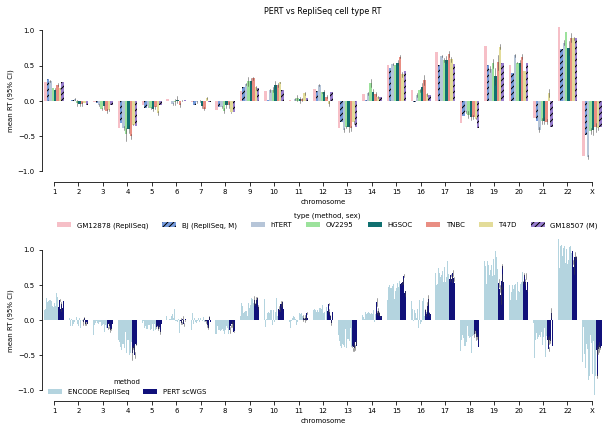

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(8.5, 6), tight_layout=True, sharey=True)

rt_by_chrom_and_type_example(combined, feature_df, ax0=ax[0], ax1=ax[1])
fig.savefig('scdna_replication_paper/manuscript/extended_data_figs/figED4.pdf', dpi=300, bbox_inches='tight')

plt.show()